## ***Sentiment Analysis Project using BERT Model***

In [5]:
import torch
import warnings
warnings.filterwarnings("ignore")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [6]:
# load BERT model

from transformers import BertModel

# download bert pretrained model

bert = BertModel.from_pretrained('bert-base-uncased') # this model was trained on lowercase text data

In [7]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
# download Bert tokenizer

from transformers import BertTokenizerFast

# load Bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case = True)

In [9]:
# input text

text = "Jim Henson was a puppeteer"

sent_id = tokenizer.encode(text,
                        # add [CLS] and [SEP] tokens
                        add_special_tokens = True,
                        # specify maximum length 
                        max_length = 10,
                        truncation = True,
                        # add pad token to the right side of the token
                        padding = 'max_length')

# print integer sequence
print(f"Integer Sequence {sent_id}")

# 101 is [CLS] token in integer
# 102 is [SEP] token in integer
# last two 0's are the result of padding to make it max_length 10

Integer Sequence [101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


In [10]:
# converting integer back to text as we can see 6 tokens generated for 5 words

print("Tokenized Text:",tokenizer.convert_ids_to_tokens(sent_id))

Tokenized Text: ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


In [11]:
# decode the tokenized text

decode = tokenizer.decode(sent_id)
print("Decode String {}".format(decode))

Decode String [CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


In [12]:
# mask to avoid performing attention on padding tokens
# mask values : 1 is for that tokens that are NOT MASKED, 0 for MASKED tokens.

att_mask = [int(tok > 0)for tok in sent_id]
print("Attention Mask",att_mask)

Attention Mask [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


***Understanding Input and Output***

In [13]:
# convert list to tensors

sent_id = torch.tensor(sent_id)
att_mask = torch.tensor(att_mask)

# reshaping tensor in the form of (batch,text length)

sent_id = sent_id.unsqueeze(0)
att_mask = att_mask.unsqueeze(0)

# printing reshaped tensor
print(sent_id)

tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


In [14]:
# pass integer sequence to the Bert Model

outputs = bert(sent_id,att_mask)

In [16]:
# unpack the output of Bert model

all_hidden_states = outputs[0]

cls_hidden_state = outputs[1]

print("Shapre of last hidden states:",all_hidden_states.shape)

print("Shapre of CLS hidden states:",cls_hidden_state.shape)

Shapre of last hidden states: torch.Size([1, 10, 768])
Shapre of CLS hidden states: torch.Size([1, 768])


In [17]:
cls_hidden_state

tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6864, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9041,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
         -0.3071, -0.3161, -

## ***Data Preparation***

In [18]:
# import tweet.csv

import pandas as pd
pd.set_option('display.max_colwidth',200)

# read csv file

tweets = pd.read_csv(r"/Users/nick_mac/Desktop/Natural-Language-Processing/BERT-Project/data/Tweets.csv")

# print top 5 rows

tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [19]:
# lets check the dataframe

tweets.shape

(14640, 15)

In [20]:
# randomly sample of tweets

tweets['text'].sample(5)

10386                   @USAirways And cherry on top-flight 880 was on runway after we landed ON TIME for 45 mins. Still didn't get half the luggage.
1462          @united you really screwed up dealing mechanical failure from Maui to San Francisco. Poor communication bad help in getting connections
8271               @JetBlue That'd be nice! Hoping to rack up enough miles to take a trip to Seattle and enjoy a perfect latte in the city of coffee.
10657        @USAirways It says to call. Before connecting, get song, dance about weather. Weather bad 3 days? Called for 2 days before. #wasteoftime
5763     @SouthwestAir my sinuses had to contend with two painful landings rather than one, and we missed a preregistration window. Beyond frustrated
Name: text, dtype: object

In [21]:
# sentiment class distribution

tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [22]:
# let's check the proportion

tweets['airline_sentiment'].value_counts(normalize=True)

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: proportion, dtype: float64

In [23]:
# saving the value counts to a list

class_count = tweets['airline_sentiment'].value_counts().to_list()
class_count

[9178, 3099, 2363]

## ***Text Cleaning***

In [24]:
import re

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'http\S+','',text)
    tokens = text.split()
    return " ".join(tokens)

In [25]:
# perform text cleaning

tweets['clean_text'] = tweets['text'].apply(preprocessor)

In [26]:
# save cleaned text and labels to the variable

text = tweets['clean_text'].values
labels = tweets['airline_sentiment'].values

In [27]:
# cleaned text

text[1:10]

array(["plus you've added commercials to the experience... tacky.",
       "i didn't today... must mean i need to take another trip!",
       'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "and it's a really big bad thing about it",
       "seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying va",
       'yes, nearly every time i fly vx this “ear worm” won’t go away :)',
       'really missed a prime opportunity for men without hats parody, there.',
       "well, i didn't…but now i do! :-d",
       "it was amazing, and arrived an hour early. you're too good to me."],
      dtype=object)

### ***Preparing Input and Output Data***

In [29]:
# importing label encode

from sklearn.preprocessing import LabelEncoder

# define label encoder
le = LabelEncoder()

# fit and transform
labels = le.fit_transform(labels)

In [31]:
# classes

print(le.classes_)
print(labels)

['negative' 'neutral' 'positive']
[1 2 1 ... 1 0 1]


Text(0.5, 1.0, 'Length of sentences')

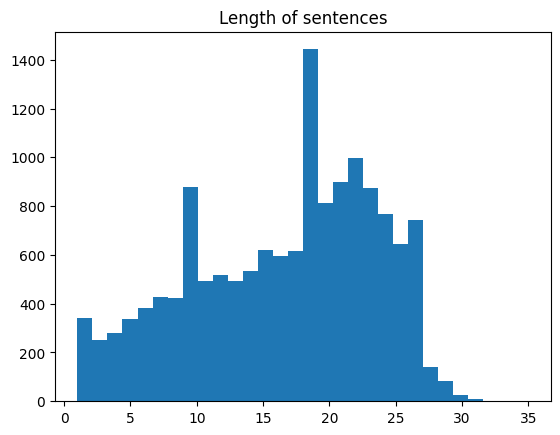

In [ ]:
# printing the sequence of the tweets

import matplotlib.pyplot as plt

num = [len(i.split()) for i in text]

plt.hist(num,bins= 30)

plt.title("Length of sentences")

# the most of the tweets hasmax length of 30

In [39]:
# define maximum length of a text

max_len = 25

In [47]:
# library for progress bar

from tqdm import tqdm

# create an empty list to save integer sequence

sent_id = []

# iterate over each tweet

for i in tqdm(range(len(text))):
    encoded_sent = tokenizer.encode(text[i],
                                    add_special_tokens = True,
                                    max_length = max_len,
                                    truncation = True,
                                    padding = 'max_length')
    
    sent_id.append(encoded_sent)

100%|██████████| 14640/14640 [00:00<00:00, 17979.52it/s]


In [48]:
print ("Integer Sequence",sent_id[0])

Integer Sequence [101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [49]:
# create attention masks
attention_masks = []

for sent in sent_id:
    att_mask = [int(token_id) > 0 for token_id in sent]

    attention_masks.append(att_mask)

### ***Training and Validation Dataset***

In [50]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(sent_id,labels, random_state= 2018,test_size= 0.1,stratify=labels)

train_masks, validation_masks, _,_ = train_test_split(attention_masks,labels,random_state= 2018,test_size= 0.1,stratify=labels)

### ***Define Data loader***

In [51]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)